In [ ]:
# EEI Global Warming Report Code
# load in the libraries

!pip install country_converter
import country_converter as coco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
import zipfile
import os
import io
import geopandas as gpd
import math
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

# Ignore warnings
warnings.filterwarnings('ignore')

In [ ]:
# download the folder with data
# On Moodle I uploaded 4 final datasets, they can be used to run
# all the neccesary code below

# for the code to run correctly you need to convert the folder into zip file
# and then upload it into this cell
from google.colab import files
all_data_folder = files.upload()

Saving data_folder.zip to data_folder (2).zip


In [ ]:
zip_filename = list(all_data_folder.keys())[0]  # Get the uploaded file name

# Extract the ZIP into a new folder
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("data_folder")


In [ ]:
import os

# list the names of files in the data folder
os.listdir("data_folder/data_folder")

['energyconsumption.csv',
 'Human_Capital_Index_WorldBank.xls',
 'epc_lad_april2020_march2021.xlsx',
 'Renewable_Energy_Consumption_WorldBank.xls',
 'world-countries.json',
 'ew_lad2023_1.json',
 'emissions.csv',
 'pwt1001.xlsx',
 'epc_lad_april2021_march2022.xlsx',
 'ew_lad2023_2.json']

In [ ]:
# download the 4 datasets



# import the energy data
energy_df1 = pd.read_csv("data_folder/data_folder/energyconsumption.csv", skiprows=1)


# import the map dataset
world_map =  gpd.read_file("data_folder/data_folder/world-countries.json")

# import the different economic variables data
economic_var_df = pd.read_excel("data_folder/data_folder/pwt1001.xlsx", sheet_name  = "Data")

# import the CO2 emmisions data
emmisions_df1 = pd.read_csv("data_folder/data_folder/emissions.csv", skiprows= 1)

In [ ]:
# Cleaning emmisions dataset

# the dataset is extremely messy

# I want to drop every even column. The years repeat and we want to avoid it
emmisions_df = emmisions_df1.copy()


emmisions_df = emmisions_df.iloc[:, [0] + list(range(1, len(emmisions_df.columns)))[::2]]

# drop second and third row
emmisions_df = emmisions_df.drop([1, 2], errors='ignore')

emmisions_df = emmisions_df.transpose()

emmisions_df.columns = emmisions_df.iloc[0]

emmisions_df = emmisions_df.reset_index(drop=True)

emmisions_df = emmisions_df.drop(0)

emmisions_df['Country'] = emmisions_df.iloc[:, 0].apply(lambda x: x.split(',')[1].strip() if isinstance(x, str) else x)

emmisions_df = emmisions_df.drop(emmisions_df.columns[0], axis=1)


emmisions_df= emmisions_df.dropna(axis=1, how='all')


for column in emmisions_df.columns[:-1]:  # Exclude the last column
    emmisions_df[column] = pd.to_numeric(emmisions_df[column], errors='coerce')

# Drop rows with NaN values in any column except the last one






cc = coco.CountryConverter()
emmisions_df['country_code'] = cc.convert(names=emmisions_df['Country'], to='ISO3')

emmisions_df = emmisions_df[emmisions_df['country_code'] != 'not found']

emmisions_df = emmisions_df.drop(columns=['Country'], errors = "ignore")

emmisions_df = emmisions_df.melt(id_vars='country_code',var_name='Year',
                                   value_name='CO2_Emmisions')

emmisions_df['Year'] = emmisions_df['Year'].astype(int)

emmisions_df = emmisions_df.dropna()

emmisions_df


,country_code,Year,CO2_Emmisions
0,ARG,1980,93.0
1,BEN,1980,0.4
2,BHR,1980,7.8
3,BRN,1980,4.5
4,CHL,1980,22.0
...,...,...,...
9318,SLB,2021,0.3
9319,SOM,2021,0.9
9320,SYR,2021,26.0
9321,TUN,2021,22.0


In [ ]:
# CLEANING THE DATASETS

# I will merge the dataset based on country codes
# This is the case as country names might differ from dataset to dataset
# (USA and UK are examples of countries that may be named differently
# in different datasets)
# energy_df here requires the most work



# NOTE
# I dropped countries that do not exist today


# select only relevant columns and rows

energy_df = energy_df1.copy()

energy_df = energy_df.iloc[1:, 1:]

energy_df.rename(columns={'Unnamed: 1': 'Country'}, inplace=True)



cc = coco.CountryConverter()
energy_df['country_code'] = cc.convert(names=energy_df['Country'], to='ISO3')



# convert numbers into correct format
energy_df.iloc[:, 1:-1] = energy_df.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce')




energy_df = energy_df[energy_df['country_code'] != 'not found']


energy_df = energy_df.drop(columns=['Country'], errors = "ignore")

energy_df_long = energy_df.melt(id_vars='country_code',var_name='Year',
                                    value_name='Energy_Consumption')



energy_df_long

# now we have a clean, long dataset

,country_code,Year,Energy_Consumption
0,AFG,1980,0.026583
1,ALB,1980,0.162982
2,DZA,1980,0.780695
3,ASM,1980,0.005893
4,AGO,1980,0.058366
...,...,...,...
9193,VNM,2021,4.265023
9194,ESH,2021,0.00374
9195,YEM,2021,0.121546
9196,ZMB,2021,0.227167


In [ ]:
# MERGED DF

# Finally we merge the datasets


world_map.rename(columns={'id': 'country_code'}, inplace=True)
world_map = world_map.drop(columns=['name'], errors = "ignore")

merge_1 = pd.merge(energy_df_long, world_map, on='country_code', how = "left")
merge_1['Year'] = merge_1['Year'].astype(int)


economic_var_df.rename(columns={'year': 'Year'}, inplace=True)
economic_var_df.rename(columns={'countrycode': 'country_code'}, inplace=True)
economic_var_df['Year'] = economic_var_df['Year'].astype(int)



merged_2 = pd.merge(merge_1, economic_var_df, on=['country_code', 'Year'], how='inner')
merged_2['Year'] = merged_2['Year'].astype(int)



merged_df = pd.merge(merged_2, emmisions_df, on=['country_code', 'Year'], how='inner')

# we will only keep few columns that we will be actively employing in the analysis
# this is done so that dropna() does not remove too many rows
columns_of_interest = ["country_code", "Year", "Energy_Consumption",
                       "geometry", "country", "rgdpe","pop","CO2_Emmisions"]




merged_df = merged_df[columns_of_interest]

# there are missing observtions for small countries:
# For example, Antiqua and Barbados. However, this should not critically
# affect the future analysis
print(merged_df.isna().sum())


# diagnostics (make sure that we do not lose data after merging)
merged_df = merged_df.dropna()

# drop the rows  where energy consumption is 0
merged_df = merged_df[merged_df['Energy_Consumption'] != 0]

merged_df
# finally we get a nice merged df


country_code            0
Year                    0
Energy_Consumption     62
geometry              749
country                 0
rgdpe                  29
pop                    29
CO2_Emmisions           0
dtype: int64


,country_code,Year,Energy_Consumption,geometry,country,rgdpe,pop,CO2_Emmisions
0,ALB,1980,0.162982,"POLYGON ((20.59025 41.8554, 20.46318 41.51509,...",Albania,9974.774414,2.682690,9.6
1,DZA,1980,0.780695,"POLYGON ((11.99951 23.47167, 8.57289 21.56566,...",Algeria,242874.890625,19.221665,46.0
2,AGO,1980,0.058366,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...",Angola,30380.066406,8.341289,3.4
4,ARG,1980,1.713088,"MULTIPOLYGON (((-65.5 -55.2, -66.45 -55.25, -6...",Argentina,130205.015625,27.896528,93.0
5,AUS,1980,2.985436,"MULTIPOLYGON (((145.39798 -40.79255, 146.36412...",Australia,349085.781250,14.588405,221.0
...,...,...,...,...,...,...,...,...
6687,VEN,2019,2.115667,"POLYGON ((-71.33158 11.77628, -71.36001 11.539...",Venezuela (Bolivarian Republic of),7166.571777,28.515829,97.0
6688,VNM,2019,4.05146,"POLYGON ((108.05018 21.55238, 106.71507 20.696...",Viet Nam,750726.750000,96.462106,292.0
6689,YEM,2019,0.158878,"POLYGON ((53.10857 16.65105, 52.38521 16.38241...",Yemen,50052.933594,29.161922,10.0
6690,ZMB,2019,0.187139,"POLYGON ((32.75938 -9.2306, 33.23139 -9.67672,...",Zambia,57956.183594,17.861030,6.0


In [ ]:
# calculate EEI for all countries

merged_df["EEI"] = merged_df["Energy_Consumption"]/merged_df["rgdpe"]

merged_df = merged_df.dropna()

# add gdp per capita

merged_df["pop"] = merged_df["pop"].astype(float)

# Calculate RGDP per capita
merged_df["RGDP_Capita"] = merged_df["rgdpe"] / merged_df["pop"]
# we divide millions by millions so the final result is correct

merged_df
# EEI is Economic output (GDP) per quad Btu of energy

,country_code,Year,Energy_Consumption,geometry,country,rgdpe,pop,CO2_Emmisions,EEI,RGDP_Capita
0,ALB,1980,0.162982,"POLYGON ((20.59025 41.8554, 20.46318 41.51509,...",Albania,9974.774414,2.682690,9.6,0.000016,3718.198679
1,DZA,1980,0.780695,"POLYGON ((11.99951 23.47167, 8.57289 21.56566,...",Algeria,242874.890625,19.221665,46.0,0.000003,12635.476200
2,AGO,1980,0.058366,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...",Angola,30380.066406,8.341289,3.4,0.000002,3642.130899
4,ARG,1980,1.713088,"MULTIPOLYGON (((-65.5 -55.2, -66.45 -55.25, -6...",Argentina,130205.015625,27.896528,93.0,0.000013,4667.427274
5,AUS,1980,2.985436,"MULTIPOLYGON (((145.39798 -40.79255, 146.36412...",Australia,349085.781250,14.588405,221.0,0.000009,23928.988896
...,...,...,...,...,...,...,...,...,...,...
6687,VEN,2019,2.115667,"POLYGON ((-71.33158 11.77628, -71.36001 11.539...",Venezuela (Bolivarian Republic of),7166.571777,28.515829,97.0,0.000295,251.319075
6688,VNM,2019,4.05146,"POLYGON ((108.05018 21.55238, 106.71507 20.696...",Viet Nam,750726.750000,96.462106,292.0,0.000005,7782.607919
6689,YEM,2019,0.158878,"POLYGON ((53.10857 16.65105, 52.38521 16.38241...",Yemen,50052.933594,29.161922,10.0,0.000003,1716.379791
6690,ZMB,2019,0.187139,"POLYGON ((32.75938 -9.2306, 33.23139 -9.67672,...",Zambia,57956.183594,17.861030,6.0,0.000003,3244.839944


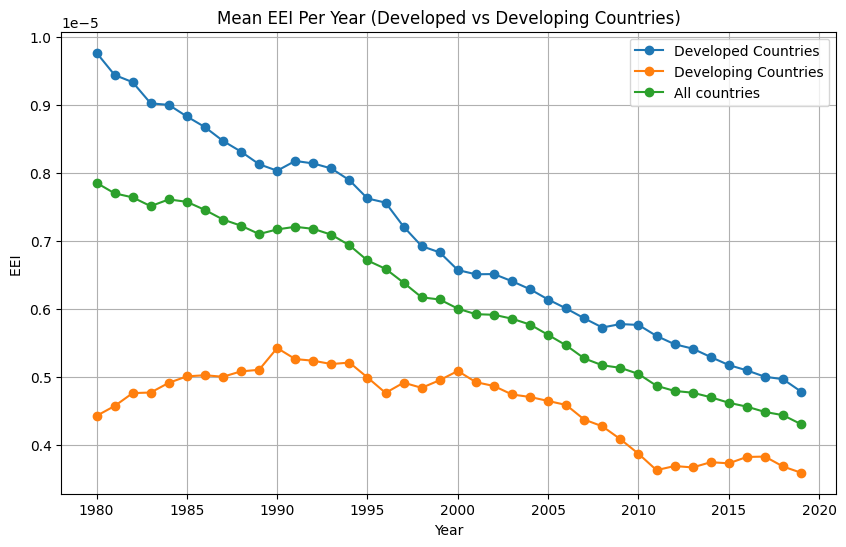

In [ ]:
# PLOTS #


# pick a sample

developed_countries = ['USA', 'GBR', 'CAN',  "JPN"]
developing_countries = ['IND','CHI',"BRA", "PAK"]

# Filter the DataFrame for developing countries
developing_df = merged_df[merged_df['country_code'].isin(developing_countries)]

developed_df = merged_df[merged_df['country_code'].isin(developed_countries)]

# Calculate the aggregate mean energy consumption per year for developed countries
mean_consumption_per_year_developed = developed_df.groupby('Year')['EEI'].mean()

# Calculate the aggregate mean energy consumption per year for developing countries
mean_consumption_per_year_developing = developing_df.groupby('Year')['EEI'].mean()


# make a plot
plt.figure(figsize=(10, 6))
plt.plot(mean_consumption_per_year_developed.index, mean_consumption_per_year_developed.values, marker='o', label='Developed Countries')
plt.plot(mean_consumption_per_year_developing.index, mean_consumption_per_year_developing.values, marker='o', label='Developing Countries')




aggregated = ['USA', 'GBR', 'CAN', "FRA", "JPN",'IND','CHI',"BRA"]

aggregated_df = merged_df[merged_df['country_code'].isin(aggregated)]

mean_aggregated = aggregated_df.groupby('Year')['EEI'].mean()

plt.plot(mean_aggregated.index, mean_aggregated.values, marker='o', label='All countries')


# Adding labels and title
plt.title('Mean EEI Per Year (Developed vs Developing Countries)')
plt.xlabel('Year')
plt.ylabel('EEI ')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# sample might look arbirtrary
# but generally, the graph looks like something below
# with most samples

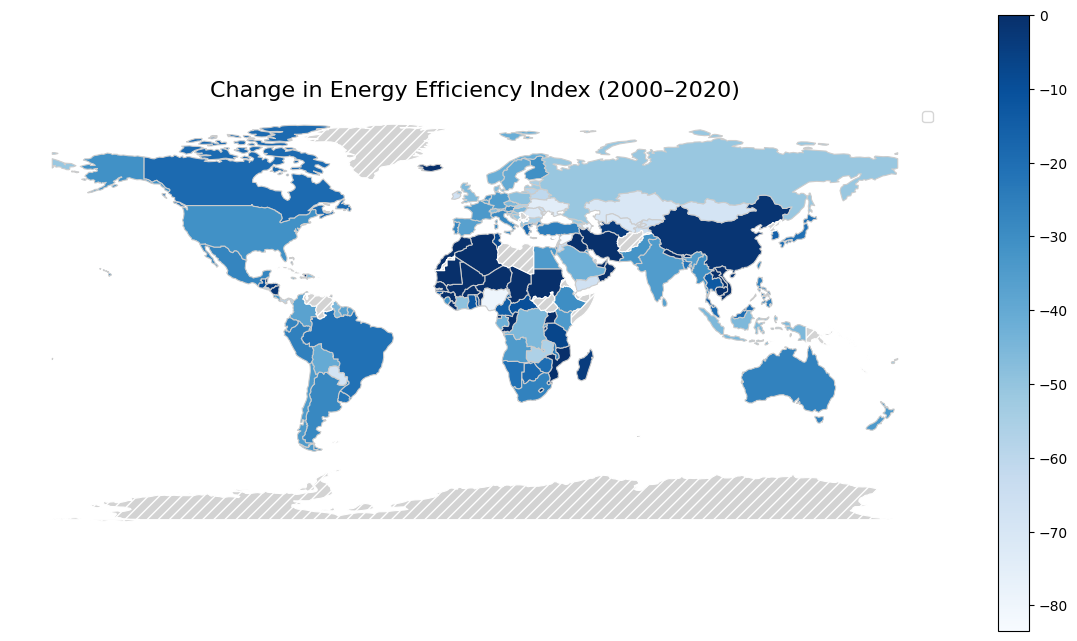

In [ ]:
# to make a map we will need to transform data a bit

# we have world map df, we will add another column
# with aggregated over years EEI and plot it


change_data = []

# Get a list of unique countries
for country in merged_df['country_code'].unique():
    # Filter data for this country
    country_data = merged_df[merged_df['country_code'] == country]

    # Get EEI values in 2000 and 2020
    eei_2000 = country_data.loc[country_data['Year'] == 2000, 'EEI'].values
    eei_2020 = country_data.loc[country_data['Year'] == 2019, 'EEI'].values

    # Make sure both years are available
    if len(eei_2000) > 0 and len(eei_2020) > 0 and eei_2000[0] != 0:
      change = (eei_2020[0] - eei_2000[0]) / eei_2000[0] * 100  # percentage change
      change_data.append({'country_code': country, 'EEI_change': change})


# convert it into data frame
change_df = pd.DataFrame(change_data)



# this code snippet makes sure that countries with no data will still exist on the map
gdf_data = pd.merge(world_map, change_df, on="country_code", how="left")



# Venezuela is a significant outlier and thus we get rid of it
# because it will poorly affect the colour scales
gdf_data.loc[gdf_data['country_code'] == 'VEN', 'EEI_change'] = np.nan


# this is for colour bar
vmin = gdf_data['EEI_change'].min()
vmax = gdf_data['EEI_change'].max()


# plot the change in EEI in the world
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

gdf_data.plot(

    column='EEI_change',
    cmap='Blues',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    vmin=vmin,
    vmax=0,
    missing_kwds={
        "color": "lightgray",        # Fill for countries with no data
        "edgecolor": "white",
        "hatch": "///",              # add stripes for better design
        "label": "No data"

    }
)

ax.set_title('Change in Energy Efficiency Index (2000–2020)', fontsize=16)
ax.axis('off')
plt.legend()
plt.show()


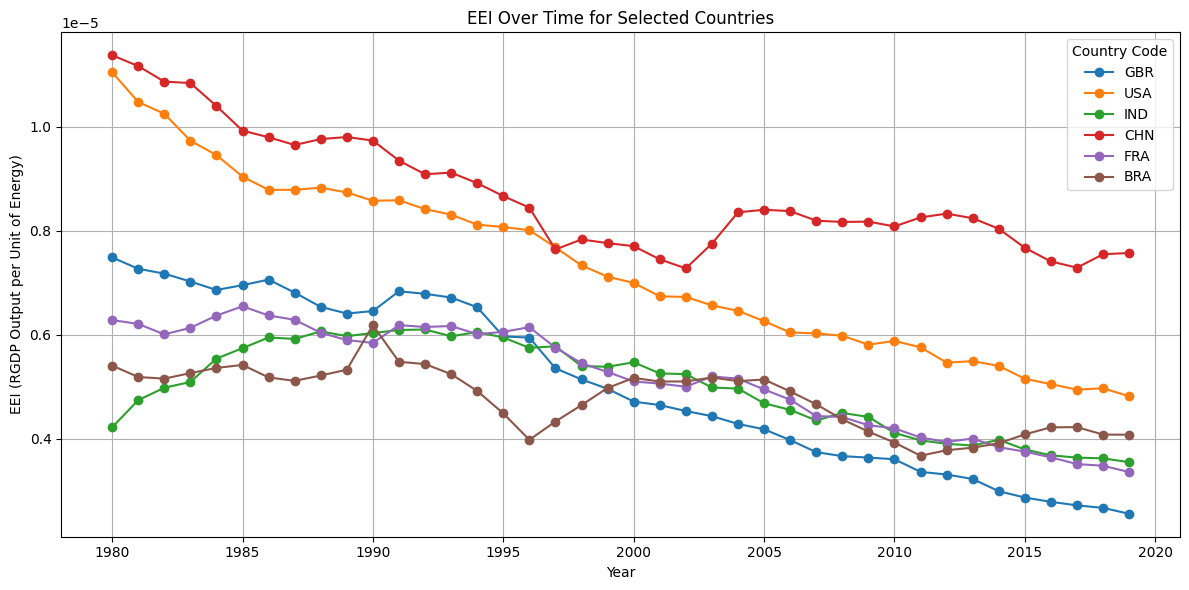

In [ ]:
# UK Energy Efficieny
# plotting a sample of countries together
def plot_eei_multiple_countries(country_codes, df):


    plt.figure(figsize=(12, 6))

    for code in country_codes:
      # filter the data for an individual country
      # and plot it
        country_df = df[df['country_code'] == code].sort_values(by='Year')
        if not country_df.empty:
            plt.plot(country_df['Year'], country_df['EEI'], marker='o', label=code)
        else:
            print(f"No data for {code}")

    plt.title('EEI Over Time for Selected Countries')
    plt.xlabel('Year')
    plt.ylabel('EEI (RGDP Output per Unit of Energy)')
    plt.grid(True)
    plt.legend(title='Country Code')
    plt.tight_layout()
    plt.show()


plot_eei_multiple_countries(['GBR', 'USA', 'IND', 'CHN',"FRA","BRA"], merged_df)

# UK seems to be ahead the rest of the sample countries

In [ ]:
# import the map datasets for UK

submap1 = gpd.read_file("data_folder/data_folder/ew_lad2023_1.json")
submap2 = gpd.read_file("data_folder/data_folder/ew_lad2023_2.json")


In [ ]:
# merge the submap datasets
merged_map = pd.concat([submap1, submap2], ignore_index=True)

merged_map

,FID,LAD23CD,LAD23NM,LAD23NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447160,531474,-1.27018,54.67614,ed77cf59-0f99-40ee-8ce0-3c495b0436dd,"MULTIPOLYGON (((-1.2247 54.62611, -1.22493 54...."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,12aebc50-49df-4d0f-af2e-7b18e5928ad7,"MULTIPOLYGON (((-1.2772 54.54784, -1.27721 54...."
2,3,E06000003,Redcar and Cleveland,,464361,519597,-1.00608,54.56752,b073197d-76d1-468b-a1ca-e71a9465fc1e,"MULTIPOLYGON (((-1.20098 54.57763, -1.2003 54...."
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,a722dfde-1ff3-4a0c-90e7-4b7cc413ba49,"MULTIPOLYGON (((-1.27211 54.55337, -1.27213 54..."
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,7341c0fb-23f7-4180-9f8f-f11c67107389,"POLYGON ((-1.63768 54.61714, -1.63767 54.6167,..."
...,...,...,...,...,...,...,...,...,...,...
313,357,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.69836,05ef8b3d-0707-4b64-839a-756f2d1a7c38,"POLYGON ((-3.1049 51.79504, -3.10171 51.79372,..."
314,358,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.77827,f5fb84c2-58a5-48f8-a95c-f99ff6f686b2,"MULTIPOLYGON (((-2.78124 51.5253, -2.78143 51...."
315,359,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.58231,f3bf10e2-5a9e-465d-a8a6-e1c3e1aa187d,"MULTIPOLYGON (((-2.95223 51.62897, -2.952 51.6..."
316,360,W06000023,Powys,Powys,302329,273254,-3.43531,52.34863,9da0c14d-8d93-4159-aa7b-d90eb47fb07b,"MULTIPOLYGON (((-3.91191 52.56285, -3.90952 52..."


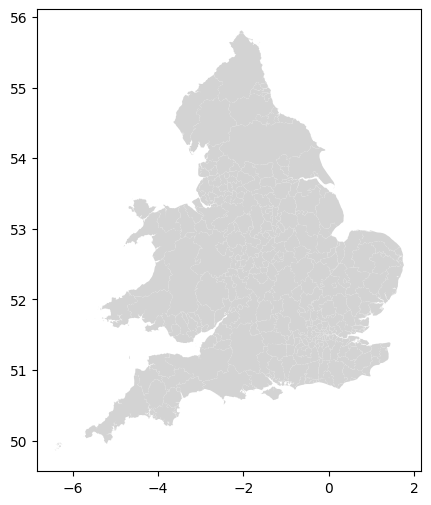

In [ ]:
# plot the empty map
merged_map.plot(figsize=(12,6), color='lightgrey')
plt.show()

In [ ]:
# download the rest of the data

# each dataset contains two sheets one for energy efficiency score
# and one for enviromental impact
# then clean the data and prepare it for merging
data_2020 = pd.read_excel("data_folder/data_folder/epc_lad_april2020_march2021.xlsx",  sheet_name="Table1", skiprows = 3)
data_2020 = data_2020.rename(columns={"All dwellings":"Energy_efficiency_score", "Local authority district code" :"LAD23CD"})

data_2020_enviroment = pd.read_excel("data_folder/data_folder/epc_lad_april2020_march2021.xlsx",  sheet_name="Table2", skiprows = 3)
data_2020["Enviromental_impact_score"] = data_2020_enviroment['All dwellings']




data_2021 = pd.read_excel("data_folder/data_folder/epc_lad_april2021_march2022.xlsx",  sheet_name="Table1", skiprows = 3)
data_2021 = data_2021.rename(columns={"All dwellings":"Energy_efficiency_score", "Local authority district code" :"LAD23CD"})

data_2021_enviroment = pd.read_excel("data_folder/data_folder/epc_lad_april2021_march2022.xlsx",  sheet_name="Table2", skiprows = 3)
data_2021["Enviromental_impact_score"] = data_2021_enviroment['All dwellings']


In [ ]:
# see the two datasets
data_2020, data_2021

(    Region code Region name    LAD23CD Local authority district name  \
 0     E12000001  North East  E06000001                    Hartlepool   
 1     E12000001  North East  E06000002                 Middlesbrough   
 2     E12000001  North East  E06000003          Redcar and Cleveland   
 3     E12000001  North East  E06000004              Stockton-on-Tees   
 4     E12000001  North East  E06000005                    Darlington   
 ..          ...         ...        ...                           ...   
 326   W92000004       Wales  W06000020                       Torfaen   
 327   W92000004       Wales  W06000021                 Monmouthshire   
 328   W92000004       Wales  W06000022                       Newport   
 329   W92000004       Wales  W06000023                         Powys   
 330   W92000004       Wales  W06000024                Merthyr Tydfil   
 
      Energy_efficiency_score  Enviromental_impact_score  
 0                         66                         64  
 1  

In [ ]:
# merge the dataset for 2020
map_2020_df = pd.merge(merged_map, data_2020, on = "LAD23CD", how="left")


map_2020_df['Enviromental_impact_score'] = pd.to_numeric(map_2020_df['Enviromental_impact_score'], errors='coerce')
map_2020_df['Energy_efficiency_score'] = pd.to_numeric(map_2020_df['Energy_efficiency_score'], errors='coerce')

map_2020_df

,FID,LAD23CD,LAD23NM,LAD23NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,Region code,Region name,Local authority district name,Energy_efficiency_score,Enviromental_impact_score
0,1,E06000001,Hartlepool,,447160,531474,-1.27018,54.67614,ed77cf59-0f99-40ee-8ce0-3c495b0436dd,"MULTIPOLYGON (((-1.2247 54.62611, -1.22493 54....",E12000001,North East,Hartlepool,66.0,64.0
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,12aebc50-49df-4d0f-af2e-7b18e5928ad7,"MULTIPOLYGON (((-1.2772 54.54784, -1.27721 54....",E12000001,North East,Middlesbrough,67.0,65.0
2,3,E06000003,Redcar and Cleveland,,464361,519597,-1.00608,54.56752,b073197d-76d1-468b-a1ca-e71a9465fc1e,"MULTIPOLYGON (((-1.20098 54.57763, -1.2003 54....",E12000001,North East,Redcar and Cleveland,65.0,62.0
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,a722dfde-1ff3-4a0c-90e7-4b7cc413ba49,"MULTIPOLYGON (((-1.27211 54.55337, -1.27213 54...",E12000001,North East,Stockton-on-Tees,67.0,64.0
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,7341c0fb-23f7-4180-9f8f-f11c67107389,"POLYGON ((-1.63768 54.61714, -1.63767 54.6167,...",E12000001,North East,Darlington,65.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,357,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.69836,05ef8b3d-0707-4b64-839a-756f2d1a7c38,"POLYGON ((-3.1049 51.79504, -3.10171 51.79372,...",W92000004,Wales,Torfaen,67.0,65.0
314,358,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.77827,f5fb84c2-58a5-48f8-a95c-f99ff6f686b2,"MULTIPOLYGON (((-2.78124 51.5253, -2.78143 51....",W92000004,Wales,Monmouthshire,66.0,63.0
315,359,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.58231,f3bf10e2-5a9e-465d-a8a6-e1c3e1aa187d,"MULTIPOLYGON (((-2.95223 51.62897, -2.952 51.6...",W92000004,Wales,Newport,68.0,65.0
316,360,W06000023,Powys,Powys,302329,273254,-3.43531,52.34863,9da0c14d-8d93-4159-aa7b-d90eb47fb07b,"MULTIPOLYGON (((-3.91191 52.56285, -3.90952 52...",W92000004,Wales,Powys,61.0,55.0


In [ ]:
# merge the dataset for year 2021
map_2021_df = pd.merge(merged_map, data_2021, on = "LAD23CD", how="left")


map_2021_df['Enviromental_impact_score'] = pd.to_numeric(map_2021_df['Enviromental_impact_score'], errors='coerce')
map_2021_df['Energy_efficiency_score'] = pd.to_numeric(map_2021_df['Energy_efficiency_score'], errors='coerce')

map_2021_df

,FID,LAD23CD,LAD23NM,LAD23NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,Region code,Region name,Local authority district name,Energy_efficiency_score,Enviromental_impact_score
0,1,E06000001,Hartlepool,,447160,531474,-1.27018,54.67614,ed77cf59-0f99-40ee-8ce0-3c495b0436dd,"MULTIPOLYGON (((-1.2247 54.62611, -1.22493 54....",E12000001,North East,Hartlepool,66.0,64.0
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,12aebc50-49df-4d0f-af2e-7b18e5928ad7,"MULTIPOLYGON (((-1.2772 54.54784, -1.27721 54....",E12000001,North East,Middlesbrough,67.0,64.0
2,3,E06000003,Redcar and Cleveland,,464361,519597,-1.00608,54.56752,b073197d-76d1-468b-a1ca-e71a9465fc1e,"MULTIPOLYGON (((-1.20098 54.57763, -1.2003 54....",E12000001,North East,Redcar and Cleveland,66.0,63.0
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,a722dfde-1ff3-4a0c-90e7-4b7cc413ba49,"MULTIPOLYGON (((-1.27211 54.55337, -1.27213 54...",E12000001,North East,Stockton-on-Tees,67.0,65.0
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,7341c0fb-23f7-4180-9f8f-f11c67107389,"POLYGON ((-1.63768 54.61714, -1.63767 54.6167,...",E12000001,North East,Darlington,65.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,357,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.69836,05ef8b3d-0707-4b64-839a-756f2d1a7c38,"POLYGON ((-3.1049 51.79504, -3.10171 51.79372,...",W92000004,Wales,Torfaen,68.0,66.0
314,358,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.77827,f5fb84c2-58a5-48f8-a95c-f99ff6f686b2,"MULTIPOLYGON (((-2.78124 51.5253, -2.78143 51....",W92000004,Wales,Monmouthshire,68.0,66.0
315,359,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.58231,f3bf10e2-5a9e-465d-a8a6-e1c3e1aa187d,"MULTIPOLYGON (((-2.95223 51.62897, -2.952 51.6...",W92000004,Wales,Newport,68.0,65.0
316,360,W06000023,Powys,Powys,302329,273254,-3.43531,52.34863,9da0c14d-8d93-4159-aa7b-d90eb47fb07b,"MULTIPOLYGON (((-3.91191 52.56285, -3.90952 52...",W92000004,Wales,Powys,62.0,56.0


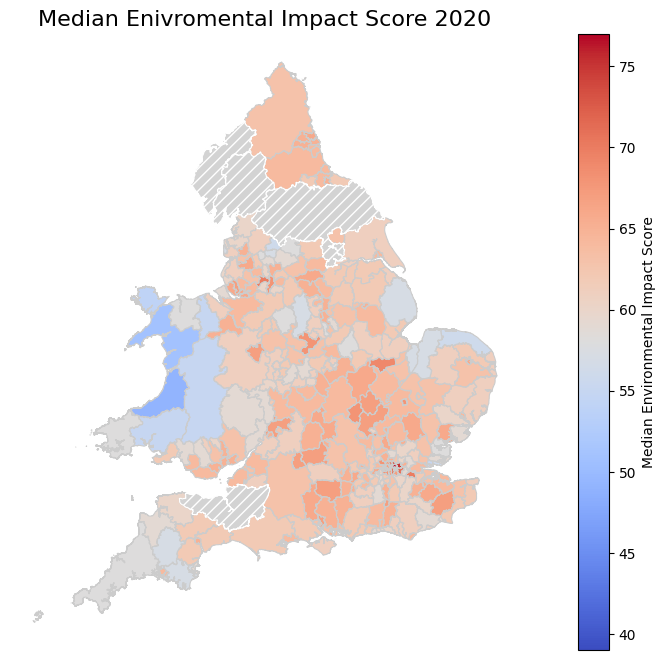

In [ ]:

# create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

map_2020_df.plot(
    # column of interest
    column='Enviromental_impact_score',
    cmap='coolwarm', # map colouring
    linewidth=0.8,
    edgecolor='0.8',
    ax=ax,
    missing_kwds={
        "color": "lightgray",        # Fill for regions with no data
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"

    }
)

# normalize the colour scale
vmin = map_2020_df['Enviromental_impact_score'].min()
vmax = map_2020_df['Enviromental_impact_score'].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# add the legend bar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm = norm)
sm._A = []  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Median Environmental Impact Score")

# show the graph
ax.set_title('Median Enivromental Impact Score 2020', fontsize=16)
ax.axis('off')
plt.show()

# the other two maps are done in almost exactly the same way

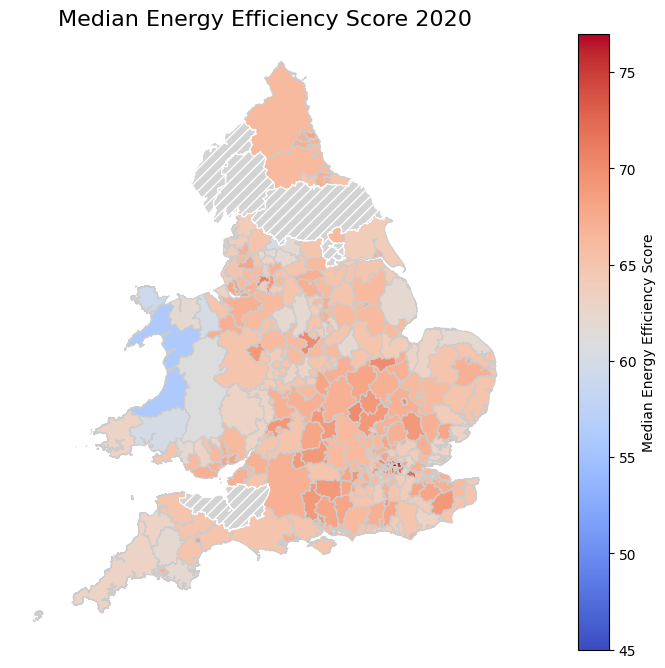

In [ ]:

# create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

map_2020_df.plot(
    # column of interest
    column='Energy_efficiency_score',
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    ax=ax,
    missing_kwds={
        "color": "lightgray",        # Fill for countries with no data
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"

    }
)

# normalize the colour scale
vmin = map_2020_df['Energy_efficiency_score'].min()
vmax = map_2020_df['Energy_efficiency_score'].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# add legend to the bar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm = norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Median Energy Efficiency Score")

# show the plot
ax.set_title('Median Energy Efficiency Score 2020', fontsize=16)
ax.axis('off')
plt.show()

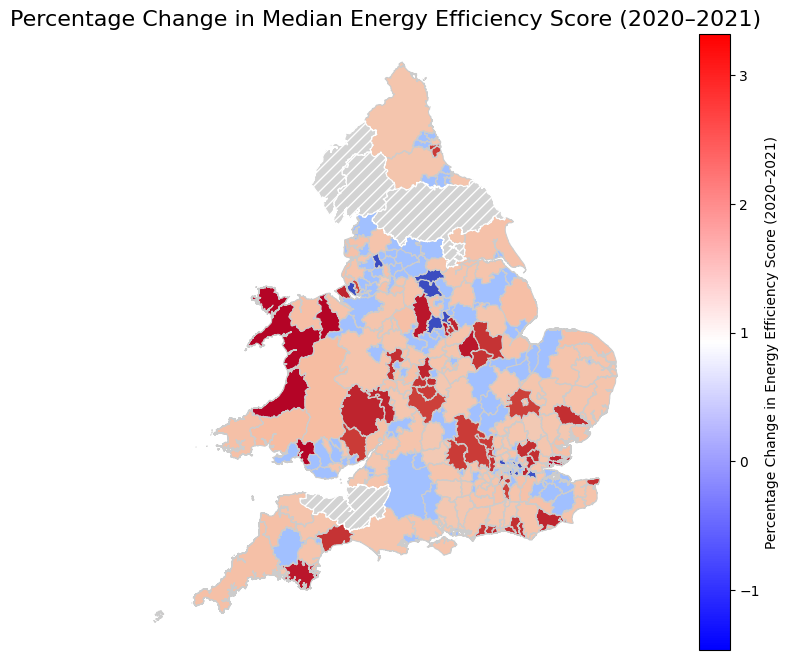

In [ ]:
# now we make plot for the change in the enviromental impact and energy efficiency

# percentage change in enviromental impact score
map_2021_df["Pct_Change_env"] = 100*(map_2021_df['Enviromental_impact_score'] - map_2020_df['Enviromental_impact_score'])/(map_2020_df['Enviromental_impact_score'])

# percentage change in energy efficiency score
map_2021_df["Pct_Change_eei"] = 100*(map_2021_df['Energy_efficiency_score'] - map_2020_df['Energy_efficiency_score'])/(map_2020_df['Energy_efficiency_score'])


# controlling for outliers, so that the colour scheme is correct on the plot
low, high = map_2021_df['Pct_Change_eei'].quantile([0.02, 0.98])
map_2021_df['Pct_Change_eei'] = np.clip(map_2021_df['Pct_Change_eei'], low, high)


# make a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

map_2021_df.plot(
    column='Pct_Change_eei',
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    legend=False,
    ax=ax,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

# Define color scale for change visualization
vmin = map_2021_df['Pct_Change_eei'].min()
vmax = map_2021_df['Pct_Change_eei'].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# add the colour bar
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Percentage Change in Energy Efficiency Score (2020–2021)")

ax.set_title('Percentage Change in Median Energy Efficiency Score (2020–2021)', fontsize=16)
ax.axis('off')

plt.show()




In [ ]:
# REGRESSIONS #
# there is a little overwrite issue in the code
# so we will have to import the stats library again here
import statsmodels.api as sm  # Re-import to fix overwrite

X2 = merged_df['rgdpe']
X2 = sm.add_constant(X2)
Y2 = merged_df['CO2_Emmisions']
Y2 = Y2.astype(float)
Y2 = Y2.dropna()

# to get clearer picture it would make sense to run log-log

model = sm.OLS(np.log(Y2), np.log(X2)).fit()
print(model.summary())


print(merged_df['CO2_Emmisions'].corr(merged_df['rgdpe']))

                                 OLS Regression Results                                
Dep. Variable:          CO2_Emmisions   R-squared (uncentered):                   0.742
Model:                            OLS   Adj. R-squared (uncentered):              0.742
Method:                 Least Squares   F-statistic:                          1.688e+04
Date:                Thu, 08 May 2025   Prob (F-statistic):                        0.00
Time:                        08:42:24   Log-Likelihood:                         -11748.
No. Observations:                5862   AIC:                                  2.350e+04
Df Residuals:                    5861   BIC:                                  2.351e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# import the dataset for human capital
# available at https://data.worldbank.org/indicator/HD.HCI.OVRL
# the reference is provided in the project report too

df11 = pd.read_excel("data_folder/data_folder/Human_Capital_Index_WorldBank.xls", sheet_name  = "Data", skiprows = 3)


df11 = df11.drop(columns=['Country Name', 'Indicator Name', 'Indicator Code'])

# convert  to long format

df11 = df11.melt(id_vars='Country Code',var_name='Year',
                                    value_name='Human_Capital')


df11 = df11.dropna()

# rename columns for merging
df11 = df11.rename(columns={'Country Code': 'country_code'})

df11

,country_code,Year,Human_Capital
3,ALB,2010,0.543603
5,ARE,2010,0.621274
6,ARG,2010,0.588557
10,AUS,2010,0.754844
11,AUT,2010,0.737782
...,...,...,...
2382,XKX,2020,0.567332
2383,YEM,2020,0.372784
2384,ZAF,2020,0.425453
2385,ZMB,2020,0.396928


In [ ]:
# download renewable energy consumption as % of GDP
# available at https://data.worldbank.org/indicator/EG.FEC.RNEW.ZS

df22= pd.read_excel("data_folder/data_folder/Renewable_Energy_Consumption_WorldBank.xls", sheet_name  = "Data", skiprows = 3)


df22 = df22.drop(columns=['Country Name', 'Indicator Name', 'Indicator Code'])


df22 = df22.melt(id_vars='Country Code',var_name='Year',
                                    value_name='Renewable_energy_pct_GDP')


df22 = df22.dropna()

df22 = df22.rename(columns={'Country Code': 'country_code'})

df22

,country_code,Year,Renewable_energy_pct_GDP
7980,ABW,1990,0.300000
7981,AFE,1990,60.910003
7982,AFG,1990,23.000000
7983,AFW,1990,85.928514
7984,AGO,1990,72.300000
...,...,...,...
16745,VCT,2022,5.100000
16747,VGB,2022,1.300000
16748,VIR,2022,5.900000
16750,VUT,2022,25.000000


In [ ]:
# merge the human capital and renewable energy
merged_df2 = pd.merge(df22,df11, on = ["country_code","Year"], how = "inner" )
merged_df2 = merged_df2.dropna()
merged_df2

,country_code,Year,Renewable_energy_pct_GDP,Human_Capital
0,ALB,2010,37.0,0.543603
1,ARE,2010,0.1,0.621274
2,ARG,2010,8.8,0.588557
3,AUS,2010,8.2,0.754844
4,AUT,2010,31.1,0.737782
...,...,...,...,...
593,WSM,2020,35.6,0.548422
594,YEM,2020,3.5,0.372784
595,ZAF,2020,9.8,0.425453
596,ZMB,2020,85.4,0.396928


In [ ]:
# now we want to merge them to merged df to run regressions

# make sure data types are the same in both datasets
merged_df['Year'] = merged_df['Year'].astype(int)
merged_df2['Year'] = merged_df2['Year'].astype(int)

# merge the data on year and country code
merged_final= pd.merge(merged_df,merged_df2, on = ["country_code","Year"], how = "inner" )
merged_final = merged_final[merged_final["Renewable_energy_pct_GDP"] != 0]
merged_final = merged_final.dropna()
merged_final

,country_code,Year,Energy_Consumption,geometry,country,rgdpe,pop,CO2_Emmisions,EEI,RGDP_Capita,Renewable_energy_pct_GDP,Human_Capital
0,ALB,2010,0.123044,"POLYGON ((20.59025 41.8554, 20.46318 41.51509,...",Albania,2.949085e+04,2.948023,3.7,0.000004,10003.600957,37.0,0.543603
1,DZA,2010,1.77776,"POLYGON ((11.99951 23.47167, 8.57289 21.56566,...",Algeria,5.156638e+05,35.977455,101.0,0.000003,14332.971683,0.3,0.531283
2,ARG,2010,3.578632,"MULTIPOLYGON (((-65.5 -55.2, -66.45 -55.25, -6...",Argentina,7.871486e+05,40.895752,186.0,0.000005,19247.686777,8.8,0.588557
3,AUS,2010,5.649744,"MULTIPOLYGON (((145.39798 -40.79255, 146.36412...",Australia,1.038250e+06,22.154679,392.0,0.000005,46863.678323,8.2,0.754844
4,AUT,2010,1.493308,"POLYGON ((16.97967 48.1235, 16.90375 47.71487,...",Austria,3.922083e+05,8.409949,70.0,0.000004,46636.225886,31.1,0.737782
...,...,...,...,...,...,...,...,...,...,...,...,...
368,URY,2018,0.228477,"POLYGON ((-57.62513 -30.2163, -56.97603 -30.10...",Uruguay,7.315374e+04,3.449285,7.3,0.000003,21208.378602,60.8,0.602368
369,VNM,2018,3.662533,"POLYGON ((108.05018 21.55238, 106.71507 20.696...",Viet Nam,7.055534e+05,95.545962,244.0,0.000005,7384.439491,24.3,0.687239
370,YEM,2018,0.122998,"POLYGON ((53.10857 16.65105, 52.38521 16.38241...",Yemen,4.869991e+04,28.498683,8.3,0.000003,1708.847607,2.9,0.372636
371,ZMB,2018,0.212673,"POLYGON ((32.75938 -9.2306, 33.23139 -9.67672,...",Zambia,5.667145e+04,17.351708,7.1,0.000004,3266.044202,83.8,0.391176


In [ ]:
# first we are going to make entity-specific, time-specific regression


# create dummies

country_dummies = pd.get_dummies(merged_final['country_code']).astype(int)

# add regressors
regressors = merged_final[["Renewable_energy_pct_GDP", "Human_Capital"]]



regressors['Human_Capital'] = regressors['Human_Capital']

# convert regressors into logs
for var in regressors:
  regressors[var] = np.log(regressors[var])

X = pd.concat([ country_dummies, regressors], axis=1)
X = X.astype(float)
X = X.dropna()

# Y
Y = merged_final['EEI']
Y = Y.astype(float)
Y = Y.dropna()
Y


# run the regression
# to get clearer picture it would make sense to run log-log

model = sm.OLS(np.log(Y), X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EEI   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     37.49
Date:                Thu, 08 May 2025   Prob (F-statistic):          2.17e-106
Time:                        08:42:39   Log-Likelihood:                 272.47
No. Observations:                 363   AIC:                            -268.9
Df Residuals:                     225   BIC:                             268.5
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
AGO                        -13.3292      0.313    -42.607      0.000     -13.946     -12.713
ALB                        -12.0080      0.222    -53.983      0.000     -12.446     -11.570
ARE                        -12.6965      0.148    -85.842      0.000     -12.988     -12.405
ARG                        -12.3492      0.177    -69.725      0.000     -12.698     -12.000
ARM                        -12.3141      0.198    -62.063      0.000     -12.705     -11.923
AUS                        -11.8681      0.145    -81.704      0.000     -12.154     -11.582
AUT                        -12.0122      0.194    -62.059      0.000     -12.394     -11.631
AZE                        -12.6816      0.157    -81.010      0.000     -12.990     -12.373
BDI                        -13.4662      0.319    -42.243      0.000     -14.094     -12.838
BEL                        -11.9232      0.146    -81.906      0.000     -12.210     -11.636
BEN                        -12.4691      0.290    -42.929      0.000     -13.041     -11.897
BFA                        -13.3156      0.321    -41.472      0.000     -13.948     -12.683
BGD                        -12.8973      0.253    -51.001      0.000     -13.396     -12.399
BGR                        -11.8258      0.183    -64.736      0.000     -12.186     -11.466
BIH                        -11.7293      0.213    -55.008      0.000     -12.149     -11.309
BRA                        -12.0096      0.241    -49.815      0.000     -12.485     -11.535
BWA                        -13.0487      0.271    -48.125      0.000     -13.583     -12.514
CAN                        -11.1059      0.176    -63.207      0.000     -11.452     -10.760
CHE                        -12.5114      0.180    -69.618      0.000     -12.866     -12.157
CHL                        -12.1370      0.198    -61.243      0.000     -12.528     -11.746
CHN                        -11.5480      0.185    -62.536      0.000     -11.912     -11.184
CIV                        -13.1543      0.323    -40.724      0.000     -13.791     -12.518
CMR                        -12.9770      0.307    -42.232      0.000     -13.583     -12.372
COD                        -13.1709      0.328    -40.128      0.000     -13.818     -12.524
COG                        -12.4743      0.291    -42.912      0.000     -13.047     -11.901
COL                        -12.5262      0.217    -57.662      0.000     -12.954     -12.098
CRI                        -12.4738      0.219    -57.039      0.000     -12.905     -12.043
CYP                        -12.2425      0.152    -80.350      0.000     -12.543     -11.942
CZE                        -11.9061      0.160    -74.353      0.000     -12.222     -11.591
DEU                        -12.1401      0.161    -75.556      0.000     -12.457     -11.823
DNK           

In [ ]:
# Final datasets
from google.colab import files
# download the final datasets

merged_df.to_csv('merged_dataset1.csv', index=False)
files.download('merged_dataset1.csv')


merged_final.to_csv('merged_dataset2.csv', index=False)
files.download('merged_dataset2.csv')

map_2020_df.to_csv('merged_dataset3.csv', index=False)
files.download('merged_dataset3.csv')

map_2021_df.to_csv('merged_dataset4.csv', index=False)
files.download('merged_dataset4.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>